# Multiscale Architecture for Implicit Neural Representation

This code defines a multiscale architecture for implicit neural representation, implementing feature encoding with Gaussian sampled features at multiple scales.

The implementation consists of two main classes:

1. **GaussianEncoding**: This class handles the positional encoding of input tensors using Gaussian sampling. The positional encodings are created by applying sine and cosine functions to the input tensors, which are scaled by Gaussian-distributed or linearly spaced frequency values.

2. **MultiScaleFourierFeatures**: This class defines the neural network that uses multiscale Fourier features for encoding input positions. The network allows for combining features from multiple scales to capture a richer representation of the input data. It includes:
   - Multiple GaussianEncoding modules, each with a different scale.
   - A series of fully connected layers that process the encoded features.
   - A final linear layer that combines the outputs from different scales.

The architecture is designed to efficiently capture spatial patterns in data by leveraging the advantages of multi-scale feature encoding.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class GaussianEncoding(nn.Module):
    def __init__(self, embedding_size, scale, dims=2, gaussian=True):
        super().__init__()
        self.embedding_size = embedding_size
        self.scale = scale

        if gaussian:
            bvals = torch.randn(embedding_size // 2, dims) * scale
        else:
            bvals = 2.0 ** torch.linspace(0, scale, embedding_size // 2) - 1

            if dims == 1:
                bvals = bvals[:, None]

            elif dims == 2:
                bvals = torch.stack([bvals, torch.zeros_like(bvals)], dim=-1)
                bvals = torch.cat([bvals, torch.roll(bvals, 1, -1)], dim=0)

            else:
                tmp = (dims - 1) * (torch.zeros_like(bvals),)
                bvals = torch.stack([bvals, *tmp], dim=-1)

                tmp = [torch.roll(bvals, i, -1) for i in range(1, dims)]
                bvals = torch.cat([bvals, *tmp], dim=0)

        avals = torch.ones((bvals.shape[0]))
        self.avals = nn.Parameter(avals, requires_grad=False)
        self.bvals = nn.Parameter(bvals, requires_grad=False)

    def forward(self, tensor) -> torch.Tensor:
        """
        Apply positional encoding to the input.
        """
        return torch.cat(
            [
                self.avals * torch.sin((2.0 * np.pi * tensor) @ self.bvals.T),
                self.avals * torch.cos((2.0 * np.pi * tensor) @ self.bvals.T),
            ],
            dim=-1,
        )

class MultiScaleFourierFeatures(nn.Module):
    def __init__(
        self,
        input_dim=2,
        output_dim=1,
        num_frequencies=8,
        width=256,
        depth=3,
        include_input=True,
        scales=[1, 5],
    ):
        super().__init__()
        self.include_input = include_input
        self.scales = scales

        self.embeddings = nn.ModuleList([GaussianEncoding(embedding_size=num_frequencies * 2, scale=scale, dims=input_dim) for scale in scales])
        embed_dim = num_frequencies * 2
        embed_dim += input_dim if include_input else 0
        self.in_channels = [embed_dim] + [width] * (depth - 1)

        self.out_channels = [width] * (depth - 1) + [width]
        self.layers = nn.ModuleList(
            [nn.Linear(self.in_channels[k], self.out_channels[k]) for k in range(depth)]
        )
        self.final_linear = nn.Linear(len(self.scales) * width, output_dim)
        self.depth = depth
        self.hidden_dim = width

    def forward(self, x):
        x_shape = x.shape[:-1]
        x = x.view(x.shape[0], -1, x.shape[-1])

        positions = [embedding(x) for embedding in self.embeddings]

        if self.include_input:
            positions = [torch.cat([pos, x], axis=-1) for pos in positions]

        pre_outs = []
        for pos in positions:
            out = pos
            for i in range(self.depth - 1):
                out = torch.relu(self.layers[i](out))
            pre_outs.append(out)

        outs = [self.layers[-1](pre_out) for pre_out in pre_outs]

        # Concatenate the outputs from each scale
        concatenated_out = torch.cat(outs, axis=-1)

        # A final linear layer to combine multi-scale outputs
        final_out = self.final_linear(concatenated_out)

        return final_out.view(*x_shape, final_out.shape[-1])




### Function to Generate a Random Signal

This code cell sets up an experiment to fit a single 1D signal using the previously defined multiscale architecture. The following functions and steps are included:

1. **`sample_random_signal(key, decay_vec)`**: Generates a random signal with a given decay vector. This function:
   - Generates a raw signal using a normal distribution.
   - Applies the decay vector to the signal in the frequency domain.
   - Converts the signal back to the time domain using the inverse Fast Fourier Transform (FFT).

2. **`sample_random_powerlaw(key, N, power)`**: Generates a random signal that follows a power-law decay. This function:
   - Creates a decay vector based on a power-law distribution.
   - Sets part of the decay vector to zero to limit the frequency range.
   - Calls `sample_random_signal` to generate the signal.



This preparation sets up the dataset for training and testing the multiscale neural network architecture on a randomly generated 1D signal.


In [2]:
## Function to generate a random signal
def sample_random_signal(key, decay_vec):
    N = decay_vec.shape[0]
    raw = np.random.normal(size=[N, 2]) @ np.array([1, 1j])
    signal_f = raw * decay_vec
    signal = np.real(np.fft.ifft(signal_f))
    return signal

def sample_random_powerlaw(key, N, power):
    coords = np.fft.ifftshift(1 + N//2 - np.abs(np.fft.fftshift(np.arange(N)) - N//2)).astype(float)
    decay_vec = coords ** -power
    decay_vec = np.array(decay_vec)
    decay_vec[N//4:] = 0
    return sample_random_signal(key, decay_vec)

# Generate the signal
rand_key = np.random.RandomState(42)
M = 8
N_train = 20
data_power = 1.5
x_test = np.linspace(0, 1., N_train * M, endpoint=False, dtype=np.float32)
x_train = x_test[::M]

test_mask = np.ones(len(x_test), bool)
test_mask[np.arange(0, x_test.shape[0], M)] = 0

s = sample_random_powerlaw(rand_key, N_train * M, data_power)
s = (s - s.min()) / (s.max() - s.min()) - 0.5

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(s[::M], dtype=torch.float32).unsqueeze(-1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(-1)




### Experiment with Different Scales for Multiscale Fourier Features

This code cell runs an experiment to fit a 1D signal using the multiscale Fourier features architecture with different scales. The steps include:

This cell allows you to visualize how well the multiscale Fourier features model can fit a 1D signal using different scales for feature encoding.


Scales [0] - Epoch [5/20], Loss: 0.0801
Scales [0] - Epoch [10/20], Loss: 0.0540
Scales [0] - Epoch [15/20], Loss: 0.0559
Scales [0] - Epoch [20/20], Loss: 0.0532
Scales [1] - Epoch [5/20], Loss: 0.0160
Scales [1] - Epoch [10/20], Loss: 0.0096
Scales [1] - Epoch [15/20], Loss: 0.0054
Scales [1] - Epoch [20/20], Loss: 0.0039
Scales [5] - Epoch [5/20], Loss: 0.0117
Scales [5] - Epoch [10/20], Loss: 0.0043
Scales [5] - Epoch [15/20], Loss: 0.0028
Scales [5] - Epoch [20/20], Loss: 0.0006
Scales [1, 5] - Epoch [5/20], Loss: 0.0065
Scales [1, 5] - Epoch [10/20], Loss: 0.0015
Scales [1, 5] - Epoch [15/20], Loss: 0.0015
Scales [1, 5] - Epoch [20/20], Loss: 0.0008


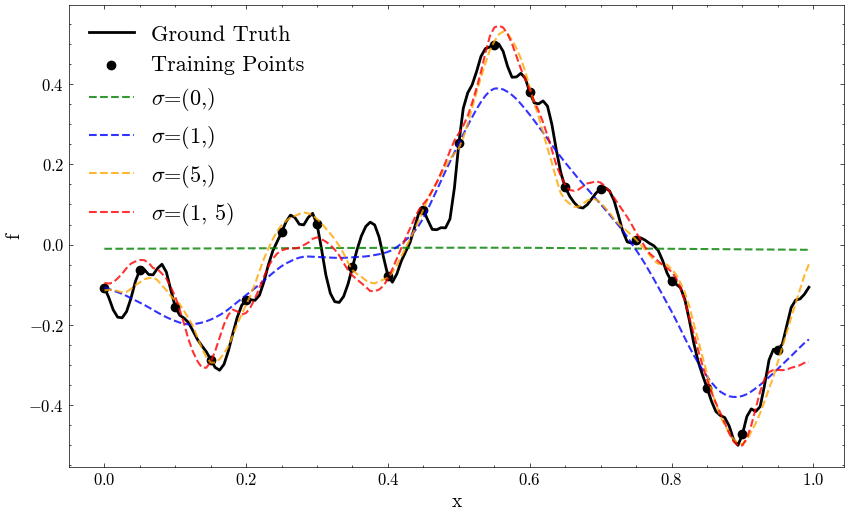

In [3]:
# Scales to test
scales_list = [ [0],[1],[5], [1, 5]]
results = {}
# Training loop for different scales
for scales in scales_list:
    # Initialize the model, loss function, and optimizer
    model = MultiScaleFourierFeatures(input_dim=1, output_dim=1, num_frequencies=8, width=256, depth=3, scales=scales)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 5 == 0:
            print(f'Scales {scales} - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Testing
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test_tensor)
    results[tuple(scales)] = y_pred.numpy()

# Plotting
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_test, s, label='Ground Truth',color='black', linewidth=2)
plt.scatter(x_train, y_train_tensor, color='black', label='Training Points')

colors = ['green', 'blue', 'orange', 'red']
for i, (scales, y_pred) in enumerate(results.items()):
    plt.plot(x_test, y_pred, color=colors[i], label=r'$\sigma$=' + str(scales), alpha=0.8,linewidth=1.5,linestyle='--')

plt.legend()
#plt.title('Multiscale Feature Encoding with Gaussian Encoding')
plt.xlabel(r'x')
plt.ylabel(r'f')
plt.savefig('/home/dmsm/gi.catalani/Projects/RAE_Transonic/INR_simple/signal_fitting.pdf')
plt.show()

## Airfoil Signed Distance Function (SDF) Analysis

This code cell defines the `AirfoilSDF` class to analyze the signed distance function (SDF) of an airfoil geometry from a given data file. 


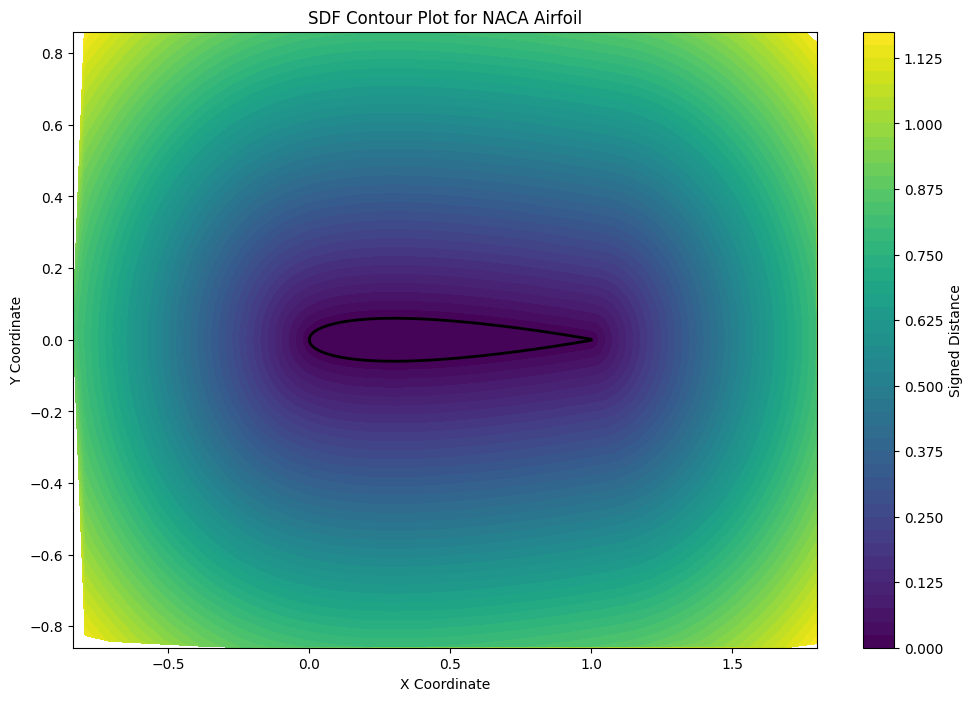

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import point_cloud_utils as pcu

class AirfoilSDF:
    """
AirfoilSDF is a class designed to analyze the signed distance function (SDF)
of an airfoil geometry from a given data file. This class handles loading and 
reordering airfoil coordinate data, creating a mesh from these coordinates, 
sampling points around the airfoil for SDF computation, and visualizing the results.

Inputs:
    filepath (str): Path to the file containing airfoil data.  
"""
    
    def __init__(self, filepath):
        # Initialize the class with the file path to the airfoil data.
        self.filepath = filepath
        self.vertices = None
        self.faces = None

    def load_and_reorder_data(self):
        # Split the data into upper and lower surfaces.
        # Reordering is necessary because data points need to be ordered from leading to trailing edge
        # for the upper surface, and from trailing edge back to leading edge for the lower surface.
        data = np.loadtxt(self.filepath, skiprows=3)
        trailing_edge_index = np.argmax(data[:, 0])
        upper_surface = data[:trailing_edge_index + 1]
        lower_surface = data[trailing_edge_index + 1:][::-1]
        self.vertices = np.vstack((upper_surface, lower_surface))
        self.vertices = np.hstack([self.vertices, np.zeros((self.vertices.shape[0], 1))])  # Convert to 3D

    def create_mesh(self):
        # Create a mesh from the vertices by defining triangular faces.
        # This mesh is necessary for computing the signed distance function (SDF).
        # We create a strip of triangles between the upper and lower surfaces to ensure a continuous surface.
        upper_len = len(self.vertices) // 2
        self.faces = []
        for i in range(upper_len - 1):
            v1, v2, v3, v4 = i, i + 1, upper_len + i, upper_len + i + 1
            self.faces.extend([[v1, v3, v2], [v2, v3, v4]])

    def sample_points(self, num_points=10000, bbox_extension=[0.8, 0.8, 0], variances=[0.05, 0.01]):
        # Determine the bounding box for the airfoil and extend it to ensure points are sampled around the airfoil.
        #Uniformly sample in the bounding box
        min_corner = self.vertices.min(axis=0) - bbox_extension
        max_corner= self.vertices.max(axis=0) + bbox_extension
        uniform_points = np.random.uniform(min_corner, max_corner, size=(num_points//2, 3))
        uniform_sdf, _, _ = pcu.signed_distance_to_mesh(uniform_points, self.vertices, np.array(self.faces))
        
        # Sample more aggresively around the airofil surface by perturbing vertices with random Gaussian noise
        perturbed_data = []
        for var in variances:
            noise = np.random.normal(scale=np.sqrt(var), size=(self.vertices.shape[0] * 30, self.vertices.shape[1]))
            perturbed_points = np.repeat(self.vertices, 30, axis=0)
            perturbed_points[:, :2] += noise[:, :2]
            perturbed_sdf, _, _ = pcu.signed_distance_to_mesh(perturbed_points, self.vertices, np.array(self.faces))
            perturbed_data.append((perturbed_points, perturbed_sdf))
        
        # Combine uniform and perturbed points and their SDF values
        all_points = uniform_points
        all_sdf = uniform_sdf

        for perturbed_points, perturbed_sdf in perturbed_data:
            all_points = np.vstack((all_points, perturbed_points))
            all_sdf = np.hstack((all_sdf, perturbed_sdf))

        return all_points, all_sdf

    def plot(self, all_points, all_sdf):
        
        # Scatter plot of all points
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(self.vertices[:, 0], self.vertices[:, 1], 'k-', linewidth=2, label='Airfoil Profile')
        scatter = ax.scatter(all_points[:, 0], all_points[:, 1], c=all_sdf, cmap='viridis', s=1)
        plt.colorbar(scatter, label='Signed Distance')
        ax.set_title('SDF Scatter Plot for NACA Airfoil')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        plt.show()

        # Contour plot using triangulation
        fig, ax = plt.subplots(figsize=(12, 8))
        contour = ax.tricontourf(all_points[:, 0], all_points[:, 1], all_sdf, levels=50, cmap='viridis')
        ax.plot(self.vertices[:, 0], self.vertices[:, 1], 'k-', linewidth=2)
        plt.colorbar(contour, label='Signed Distance')
        ax.set_title('SDF Contour Plot for NACA Airfoil')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        plt.show()

file_path = '/home/dmsm/gi.catalani/Projects/Aero_Nepf/naca_0012.dat'

airfoil_sdf = AirfoilSDF(file_path)
airfoil_sdf.load_and_reorder_data()
airfoil_sdf.create_mesh()
points, sdf = airfoil_sdf.sample_points()
airfoil_sdf.plot(points,sdf)


### Training Multiscale Fourier Features to Learn Airfoil Shape Representations

This code cell trains the `MultiScale Fourier Features` model to learn the shape representations of an airfoil using the point cloud data generated by the `AirfoilSDF` class.


Scales [1, 5] - Epoch [5/500], Loss: 0.073372
Scales [1, 5] - Epoch [10/500], Loss: 0.042855
Scales [1, 5] - Epoch [15/500], Loss: 0.019299
Scales [1, 5] - Epoch [20/500], Loss: 0.010966
Scales [1, 5] - Epoch [25/500], Loss: 0.006424
Scales [1, 5] - Epoch [30/500], Loss: 0.003764
Scales [1, 5] - Epoch [35/500], Loss: 0.002388
Scales [1, 5] - Epoch [40/500], Loss: 0.001388
Scales [1, 5] - Epoch [45/500], Loss: 0.001164
Scales [1, 5] - Epoch [50/500], Loss: 0.000957


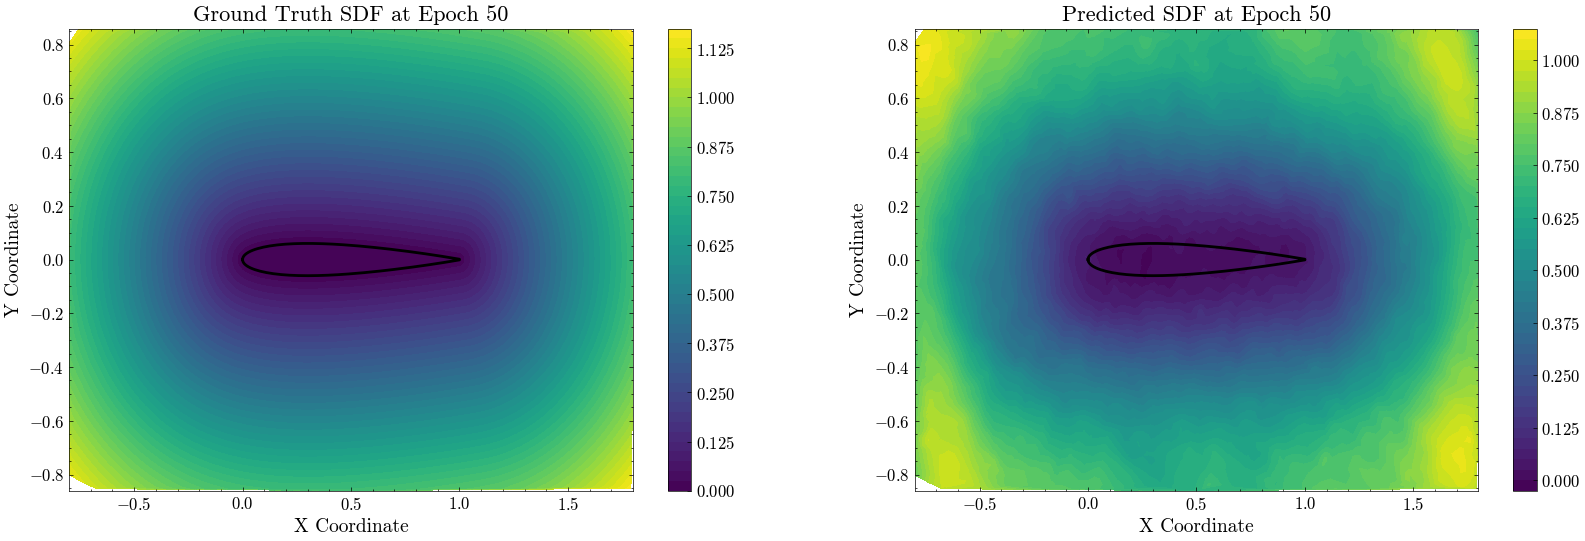

Scales [1, 5] - Epoch [55/500], Loss: 0.000593
Scales [1, 5] - Epoch [60/500], Loss: 0.000448
Scales [1, 5] - Epoch [65/500], Loss: 0.000378
Scales [1, 5] - Epoch [70/500], Loss: 0.000273
Scales [1, 5] - Epoch [75/500], Loss: 0.000234
Scales [1, 5] - Epoch [80/500], Loss: 0.000179
Scales [1, 5] - Epoch [85/500], Loss: 0.000155
Scales [1, 5] - Epoch [90/500], Loss: 0.000130
Scales [1, 5] - Epoch [95/500], Loss: 0.000112
Scales [1, 5] - Epoch [100/500], Loss: 0.000100


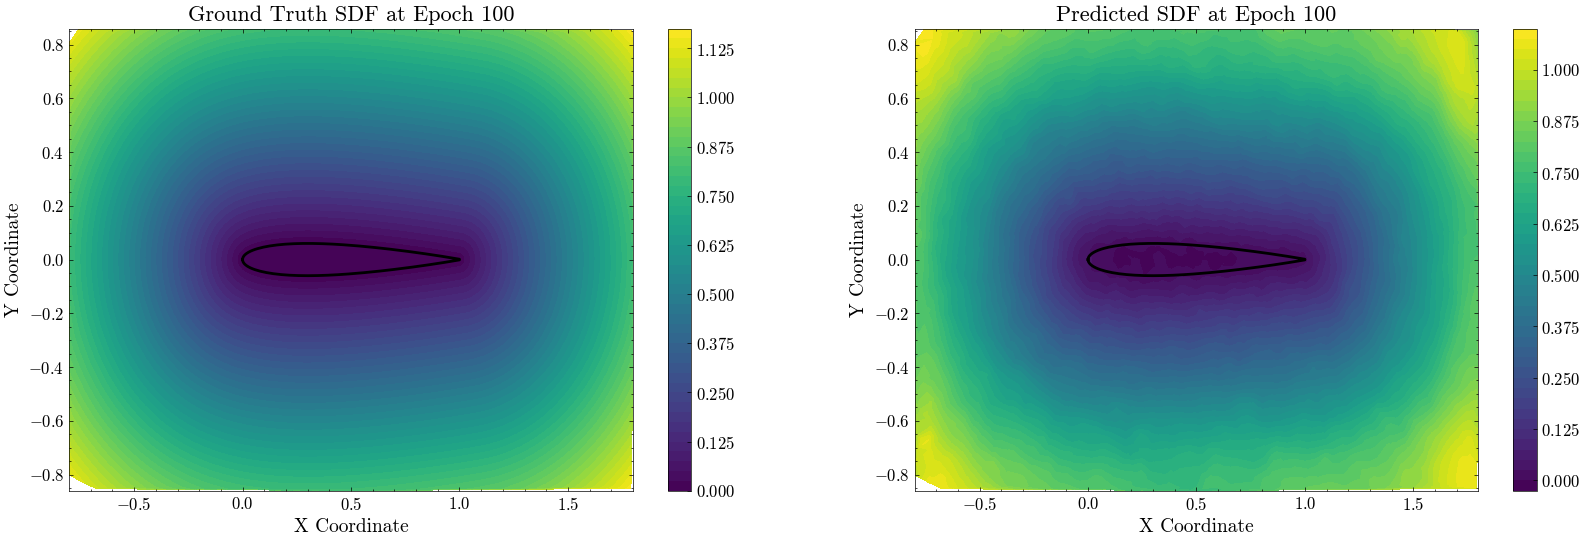

Scales [1, 5] - Epoch [105/500], Loss: 0.000089
Scales [1, 5] - Epoch [110/500], Loss: 0.000080
Scales [1, 5] - Epoch [115/500], Loss: 0.000073
Scales [1, 5] - Epoch [120/500], Loss: 0.000067
Scales [1, 5] - Epoch [125/500], Loss: 0.000061
Scales [1, 5] - Epoch [130/500], Loss: 0.000057
Scales [1, 5] - Epoch [135/500], Loss: 0.000052
Scales [1, 5] - Epoch [140/500], Loss: 0.000049
Scales [1, 5] - Epoch [145/500], Loss: 0.000046
Scales [1, 5] - Epoch [150/500], Loss: 0.000043


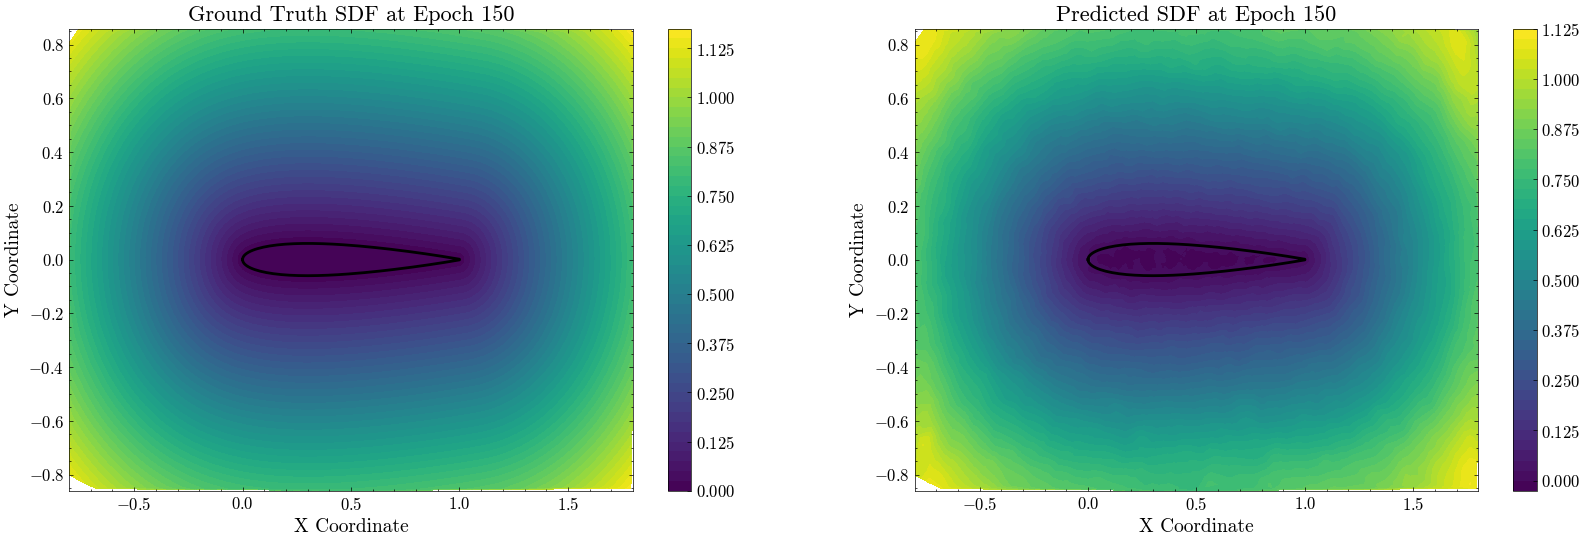

Scales [1, 5] - Epoch [155/500], Loss: 0.000040
Scales [1, 5] - Epoch [160/500], Loss: 0.000038
Scales [1, 5] - Epoch [165/500], Loss: 0.000036
Scales [1, 5] - Epoch [170/500], Loss: 0.000034
Scales [1, 5] - Epoch [175/500], Loss: 0.000032
Scales [1, 5] - Epoch [180/500], Loss: 0.000030
Scales [1, 5] - Epoch [185/500], Loss: 0.000029
Scales [1, 5] - Epoch [190/500], Loss: 0.000027
Scales [1, 5] - Epoch [195/500], Loss: 0.000026
Scales [1, 5] - Epoch [200/500], Loss: 0.000025


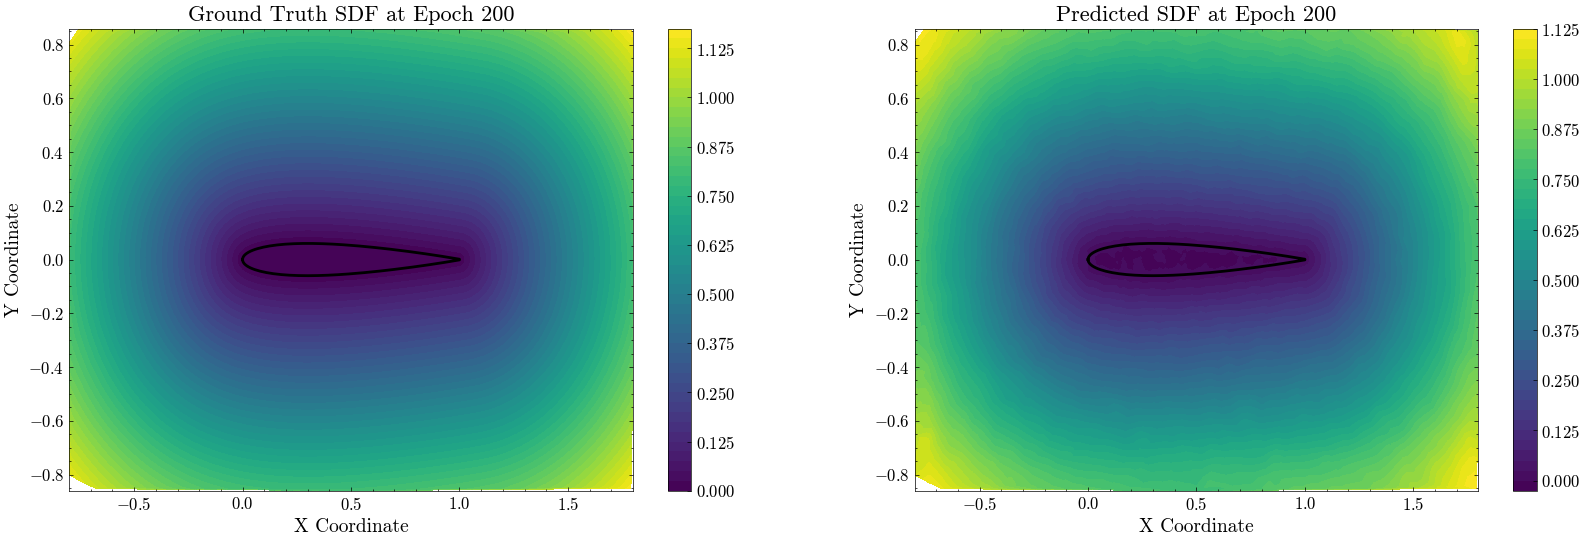

Scales [1, 5] - Epoch [205/500], Loss: 0.000024
Scales [1, 5] - Epoch [210/500], Loss: 0.000023
Scales [1, 5] - Epoch [215/500], Loss: 0.000022
Scales [1, 5] - Epoch [220/500], Loss: 0.000021
Scales [1, 5] - Epoch [225/500], Loss: 0.000020
Scales [1, 5] - Epoch [230/500], Loss: 0.000019
Scales [1, 5] - Epoch [235/500], Loss: 0.000018
Scales [1, 5] - Epoch [240/500], Loss: 0.000017
Scales [1, 5] - Epoch [245/500], Loss: 0.000017
Scales [1, 5] - Epoch [250/500], Loss: 0.000016


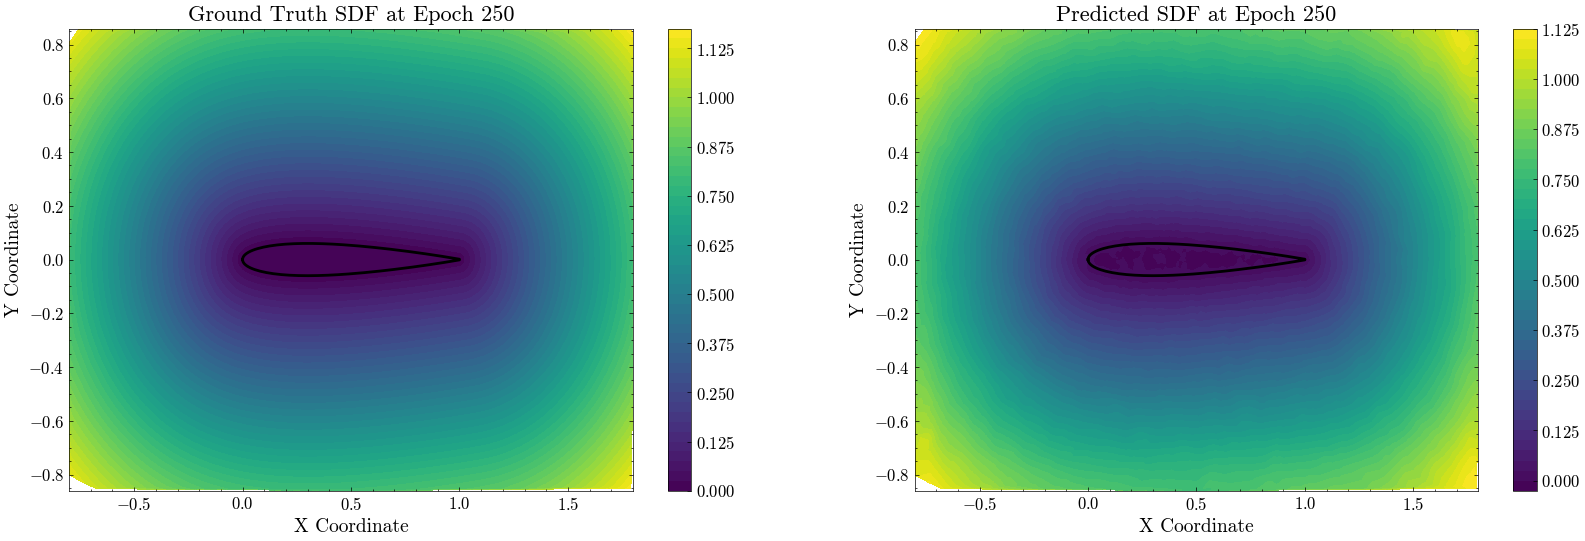

Scales [1, 5] - Epoch [255/500], Loss: 0.000016
Scales [1, 5] - Epoch [260/500], Loss: 0.000015
Scales [1, 5] - Epoch [265/500], Loss: 0.000014
Scales [1, 5] - Epoch [270/500], Loss: 0.000014
Scales [1, 5] - Epoch [275/500], Loss: 0.000013
Scales [1, 5] - Epoch [280/500], Loss: 0.000013
Scales [1, 5] - Epoch [285/500], Loss: 0.000013
Scales [1, 5] - Epoch [290/500], Loss: 0.000012
Scales [1, 5] - Epoch [295/500], Loss: 0.000012
Scales [1, 5] - Epoch [300/500], Loss: 0.000011


Scales [1, 5] - Epoch [305/500], Loss: 0.000011
Scales [1, 5] - Epoch [310/500], Loss: 0.000011
Scales [1, 5] - Epoch [315/500], Loss: 0.000010
Scales [1, 5] - Epoch [320/500], Loss: 0.000010
Scales [1, 5] - Epoch [325/500], Loss: 0.000010
Scales [1, 5] - Epoch [330/500], Loss: 0.000010
Scales [1, 5] - Epoch [335/500], Loss: 0.000009
Scales [1, 5] - Epoch [340/500], Loss: 0.000009
Scales [1, 5] - Epoch [345/500], Loss: 0.000009
Scales [1, 5] - Epoch [350/500], Loss: 0.000009


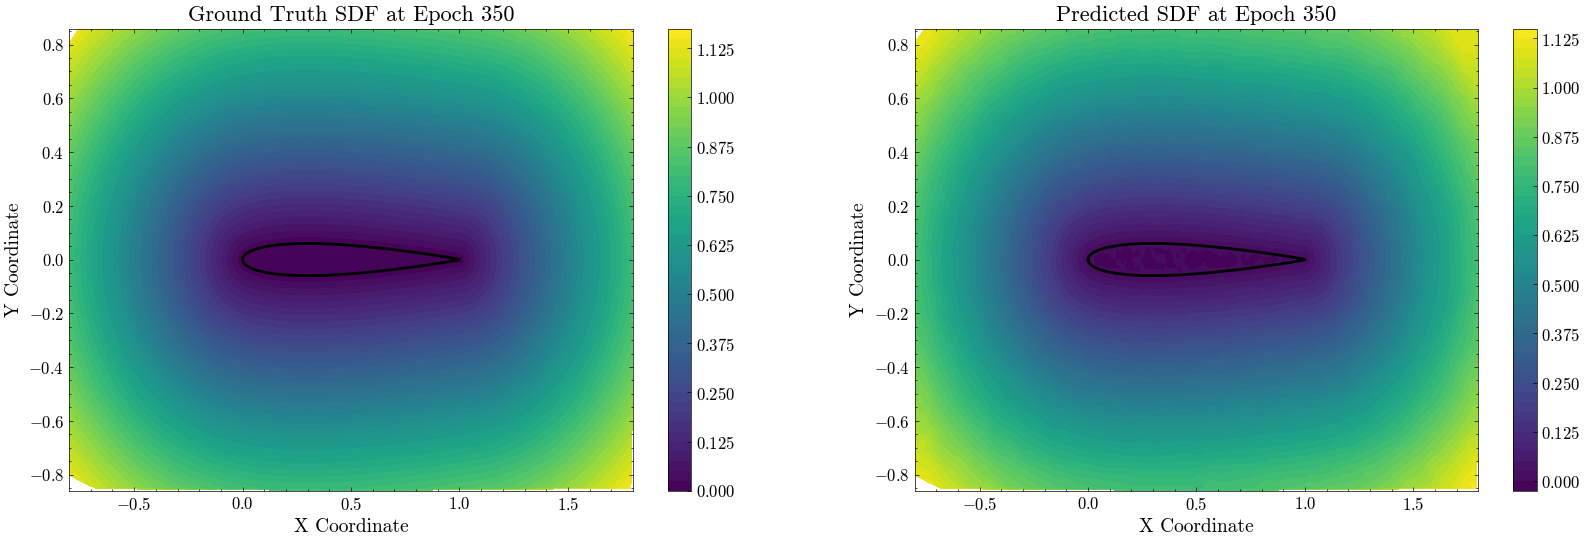

Scales [1, 5] - Epoch [355/500], Loss: 0.000008
Scales [1, 5] - Epoch [360/500], Loss: 0.000008
Scales [1, 5] - Epoch [365/500], Loss: 0.000008
Scales [1, 5] - Epoch [370/500], Loss: 0.000008
Scales [1, 5] - Epoch [375/500], Loss: 0.000008
Scales [1, 5] - Epoch [380/500], Loss: 0.000008
Scales [1, 5] - Epoch [385/500], Loss: 0.000007
Scales [1, 5] - Epoch [390/500], Loss: 0.000007
Scales [1, 5] - Epoch [395/500], Loss: 0.000007
Scales [1, 5] - Epoch [400/500], Loss: 0.000007


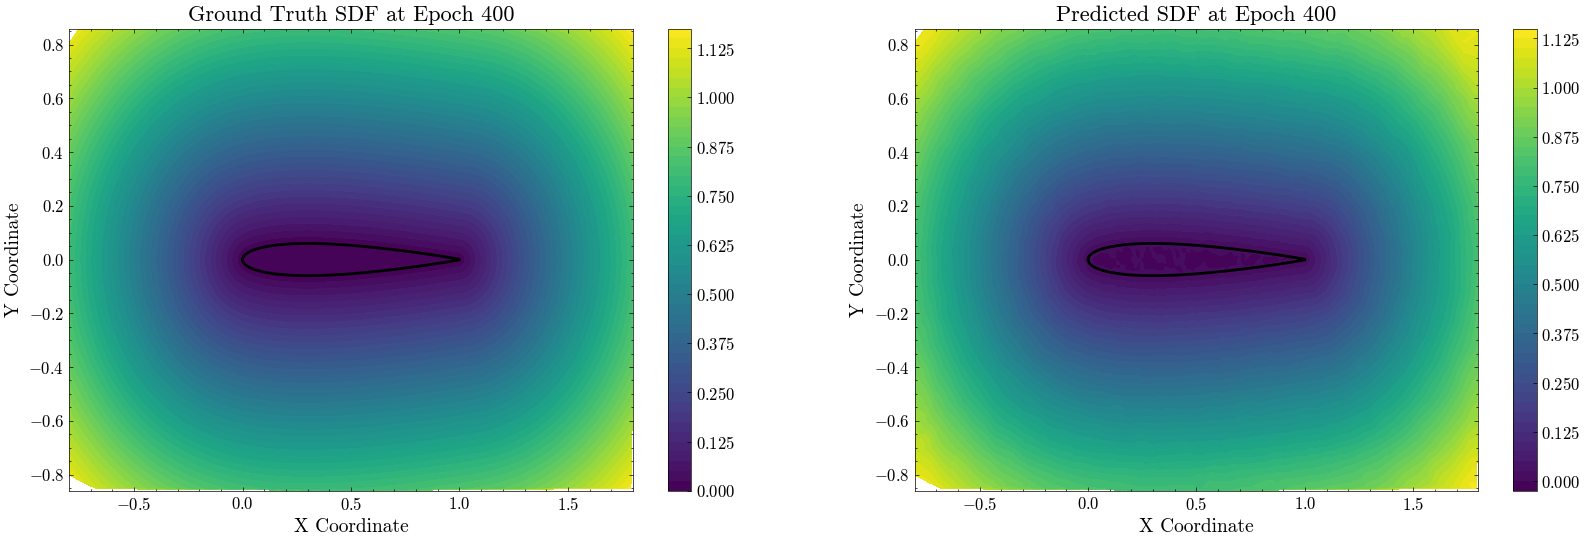

Scales [1, 5] - Epoch [405/500], Loss: 0.000007
Scales [1, 5] - Epoch [410/500], Loss: 0.000007
Scales [1, 5] - Epoch [415/500], Loss: 0.000006
Scales [1, 5] - Epoch [420/500], Loss: 0.000006
Scales [1, 5] - Epoch [425/500], Loss: 0.000006
Scales [1, 5] - Epoch [430/500], Loss: 0.000006
Scales [1, 5] - Epoch [435/500], Loss: 0.000006
Scales [1, 5] - Epoch [440/500], Loss: 0.000006
Scales [1, 5] - Epoch [445/500], Loss: 0.000006
Scales [1, 5] - Epoch [450/500], Loss: 0.000006


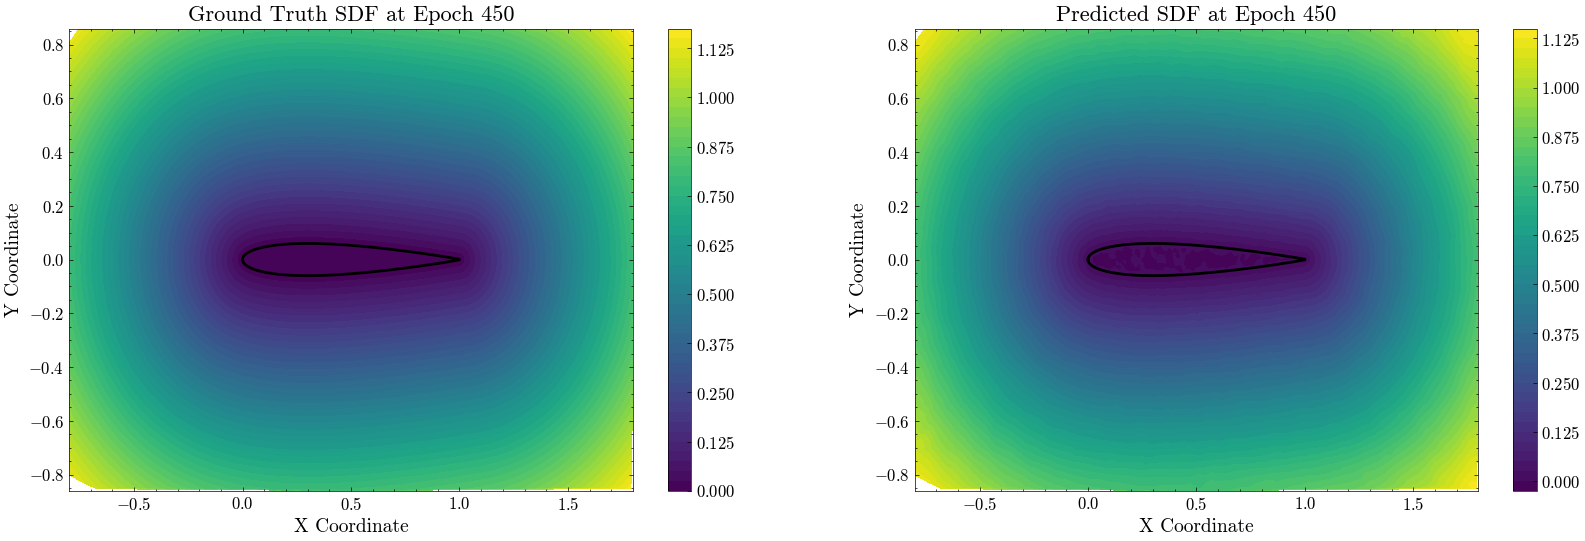

Scales [1, 5] - Epoch [455/500], Loss: 0.000005
Scales [1, 5] - Epoch [460/500], Loss: 0.000005
Scales [1, 5] - Epoch [465/500], Loss: 0.000005
Scales [1, 5] - Epoch [470/500], Loss: 0.000005
Scales [1, 5] - Epoch [475/500], Loss: 0.000005
Scales [1, 5] - Epoch [480/500], Loss: 0.000005
Scales [1, 5] - Epoch [485/500], Loss: 0.000005
Scales [1, 5] - Epoch [490/500], Loss: 0.000005
Scales [1, 5] - Epoch [495/500], Loss: 0.000005
Scales [1, 5] - Epoch [500/500], Loss: 0.000005


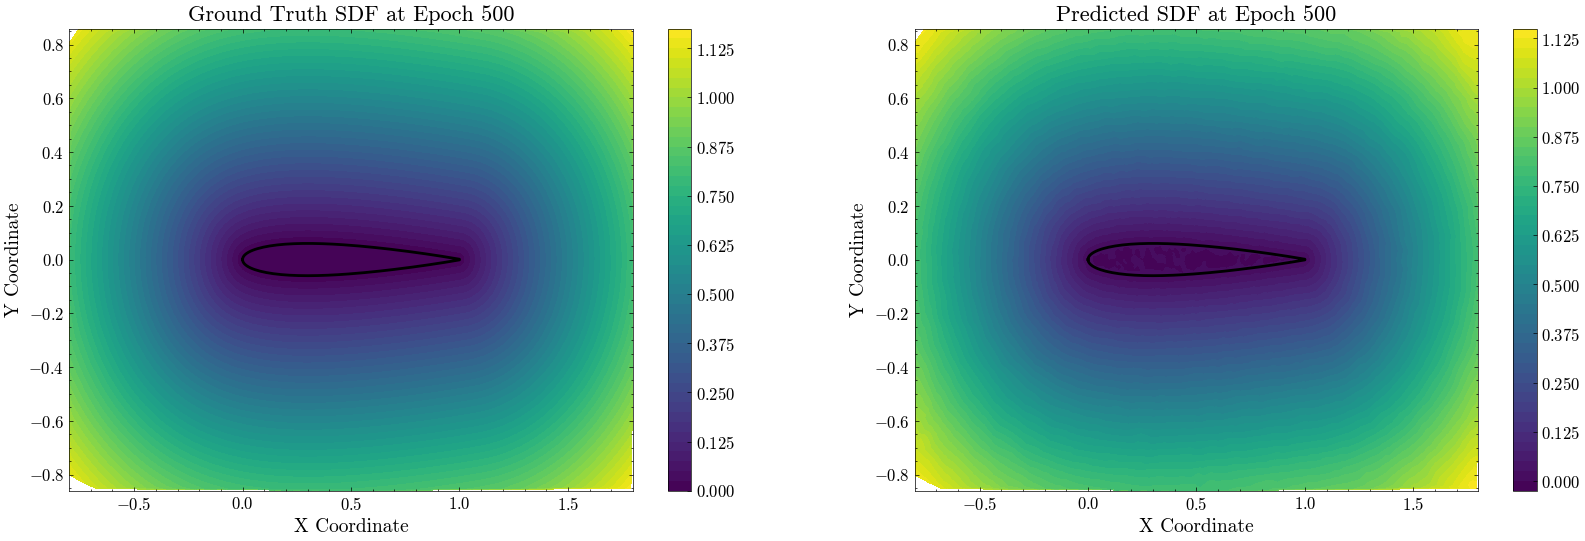

In [30]:
# Convert to PyTorch tensors
x_tensor = torch.tensor(points[:,:2], dtype=torch.float32)
y_tensor = torch.tensor(sdf, dtype=torch.float32).unsqueeze(-1)

scales = [1,5]
# Initialize the model, loss function, and optimizer
model = MultiScaleFourierFeatures(input_dim=2, output_dim=1, num_frequencies=8, width=256, depth=4, scales=scales)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Scales {scales} - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    if (epoch + 1) % 50 == 0:   
        # Testing
        model.eval()
        with torch.no_grad():
            y_pred = model(x_tensor)
        
        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))

        # Ground Truth
        c1 = axs[0].tricontourf(points[:, 0], points[:, 1], sdf, levels=50, cmap='viridis')
        axs[0].plot(airfoil_sdf.vertices[:, 0], airfoil_sdf.vertices[:, 1], 'k-', linewidth=2)
        fig.colorbar(c1, ax=axs[0])
        axs[0].set_title(f'Ground Truth SDF at Epoch {epoch+1}')
        axs[0].set_xlabel('X Coordinate')
        axs[0].set_ylabel('Y Coordinate')

        # Predicted SDF
        c2 = axs[1].tricontourf(points[:, 0], points[:, 1], y_pred.numpy().squeeze(), levels=50, cmap='viridis')
        axs[1].plot(airfoil_sdf.vertices[:, 0], airfoil_sdf.vertices[:, 1], 'k-', linewidth=2)
        fig.colorbar(c2, ax=axs[1])
        axs[1].set_title(f'Predicted SDF at Epoch {epoch+1}')
        axs[1].set_xlabel('X Coordinate')
        axs[1].set_ylabel('Y Coordinate')

        plt.show()

In [13]:
class BaseBiInvariant(nn.Module):
    """Base class for bi-invariants. Bi-invariants are functions that are invariant to the simultaneous action of a
    group on the input and latent poses.

    The base class provides a common interface for all bi-invariants. Subclasses must implement the __call__ method.

    The following properties must be set in the subclass:
    - dim: The dimensionality of the bi-invariant.
    - num_x_pos_dims: The number of spatial dimensions for the input coordinates.
    - num_x_ori_dims: The number of orientation dimensions for the input orientations.
    - num_z_pos_dims: The number of spatial dimensions for the latent coordinates.
    - num_z_ori_dims: The number of orientation dimensions for the latent orientations.
    """

    def __init__(self):
        super(BaseBiInvariant, self).__init__()
        self.dim = None
        self.num_x_pos_dims = None
        self.num_x_ori_dims = None
        self.num_z_pos_dims = None
        self.num_z_ori_dims = None

    def calculate_gaussian_window(self, x, p, sigma):
        """ Calculate the gaussian window in $R^n$.

        Args:
            x (torch.Tensor): The pose of the input coordinates. Shape (batch_size, num_coords, num_x_pos_dims).
            p (torch.Tensor): The pose of the latent points. Shape (batch_size, num_latents, num_z_pos_dims).
            sigma (torch.Tensor): The standard deviation of the gaussian window. Shape (batch_size, num_latents).

        Returns:
            torch.Tensor: The gaussian window value. Shape (batch_size, num_coords, num_latents, 1).
        """
        p_pos = p[:, :, :self.num_z_pos_dims]
        x_pos = x[:, :, :self.num_x_pos_dims]

        norm_rel_dists = torch.sum((p_pos[:, None, :, :] - x_pos[:, :, None, :]) ** 2, dim=-1, keepdim=True)
        return - (1 / sigma[:, None, :] ** 2) * norm_rel_dists
    
class RnBiInvariant(BaseBiInvariant):
    def __init__(self, num_dims: int):
        """ Calculate the relative position between two sets of coordinates in N dimensions.

        Args:
            num_dims (int): The dimensionality of the coordinates, corresponds to the dimensionality of the translation
                group.
        """
        super().__init__()
        self.dim = num_dims
        self.num_x_pos_dims = num_dims
        self.num_x_ori_dims = 0
        self.num_z_pos_dims = num_dims
        self.num_z_ori_dims = 0

    def __call__(self, x, p):
        """
        Calculate the relative position between two sets of coordinates in N dimensions.

        Args:
            x (torch.Tensor): The pose of the input coordinates. Shape (batch_size, num_coords, num_x_pos_dims).
            p (torch.Tensor): The pose of the latent points. Shape (batch_size, num_latents, num_z_pos_dims).

        Returns:
            torch.Tensor: The relative position between x and p.
                Shape (batch_size, num_coords, num_latents, num_x_pos_dims).
        """
        return x[:, :, None, :self.num_x_pos_dims] - p[:, None, :, :self.num_z_pos_dims]

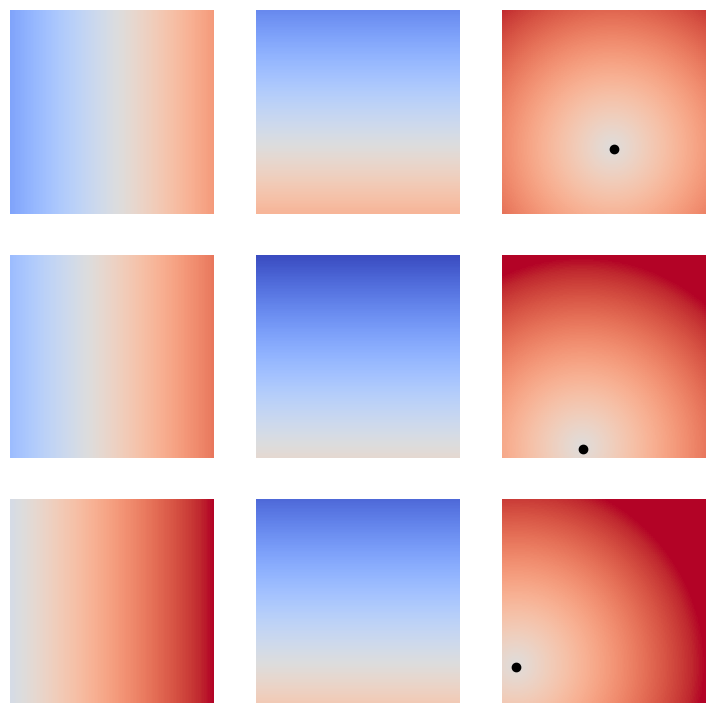

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [3, 3]

# Set grid resolution number of steps, and number of latents.
num_steps = 100
num_latents = 3

# Create a batch (with 1 sample) of 100 input coordinates on a 2D grid.
x = np.stack(np.meshgrid(np.linspace(-1, 1, num_steps), np.linspace(-1, 1, num_steps)), axis=-1).reshape(-1, 2)[None, ...]
x = torch.tensor(x, dtype=torch.float32)  # (1, 10000, 2)

# Create a batch (with 1 sample) of 3 latent coordinates.
p = torch.rand(1, num_latents, 2) * 2 - 1  # (1, num_latents, 2)

# Create the bi-invariant for 2D translations.
bi_invariant = RnBiInvariant(num_dims=2)

# Calculate the bi-invariant between the input coordinates and the latent coordinates.
bi_invariant_values = bi_invariant(x, p)  # (1, 10000, num_latents, 2)

# Visualize the bi-invariants.
fig, axs = plt.subplots(num_latents, 3, figsize=(9, num_latents * 3))
vmin, vmax = bi_invariant_values.min(), bi_invariant_values.max()

for i in range(num_latents):
    for j in range(2):
        axs[i, j].imshow(bi_invariant_values[0, :, i, j].reshape(num_steps, num_steps), cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[i, j].axis('off')
    
    # Plot the latent position, and the norm of the bi-invariant.
    p_norm = (p + 1) / 2 * num_steps
    axs[i, 2].scatter(p_norm[0, i, 0].numpy(), p_norm[0, i, 1].numpy(), color='black', label='Latent')
    norm_bi_invariant = torch.norm(bi_invariant_values[0, :, i, :], dim=-1).reshape(num_steps, num_steps)
    axs[i, 2].imshow(norm_bi_invariant.numpy(), cmap='coolwarm', vmin=vmin, vmax=vmax)
    axs[i, 2].axis('off')

plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
class RFFEmbedding(nn.Module):
    def __init__(self, embedding_dim, learnable_coefficients, std):
        super(RFFEmbedding, self).__init__()
        assert embedding_dim % 2 == 0, "For the Fourier Features hidden_dim should be even to calculate them correctly."
        self.embedding_dim = embedding_dim
        self.learnable_coefficients = learnable_coefficients
        self.std = std
        self.pi = 2 * np.pi

        self.coefficients = nn.Linear(2, embedding_dim // 2, bias=False)
        nn.init.normal_(self.coefficients.weight, std=1)

    def forward(self, x):
        x = self.pi * x
        if self.learnable_coefficients:
            parsed_coefficients = self.coefficients(x)
        else:
            with torch.no_grad():
                parsed_coefficients = self.coefficients(x)

        sin = torch.sin(self.std * parsed_coefficients)
        cos = torch.cos(self.std * parsed_coefficients)
        return torch.cat([sin, cos], dim=-1)



In [19]:
# Create an RFF embedding with dim 32
rff = RFFEmbedding(embedding_dim=32, learnable_coefficients=False, std=1.0)

# Embed the input coordinates
x_emb = rff(x)

# Apply a random map 32 -> 1 for visualization
W = torch.randn(32, 1)
x_emb = x_emb @ W

# Visualize
x_emb = (x_emb - x_emb.min()) / (x_emb.max() - x_emb.min())
plt.imshow(x_emb[0].reshape(num_steps, num_steps, 1).detach().numpy(), vmin=x_emb.min(), vmax=x_emb.max(), cmap='coolwarm')
plt.axis('off')
plt.title("RFF embedding over input domain.")
plt.show()

In [27]:
class EquivariantCrossAttention(nn.Module):
    def __init__(self, num_hidden, num_heads, bi_invariant, embedding_freq_multiplier):
        super(EquivariantCrossAttention, self).__init__()
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        self.bi_invariant = bi_invariant
        self.embedding_freq_multiplier = embedding_freq_multiplier

        self.emb_q = RFFEmbedding(embedding_dim=num_hidden * 2, learnable_coefficients=False, std=embedding_freq_multiplier)  # Corrected to num_hidden * 2
        self.emb_to_q = nn.Linear(num_hidden * 2, num_heads * num_hidden)  # Corrected to num_hidden * 2
        self.c_to_kv = nn.Linear(num_hidden, 2 * num_heads * num_hidden)
        self.out_proj = nn.Linear(num_heads * num_hidden, num_hidden)
        self.scale = 1.0 / (num_hidden ** 0.5)

    def forward(self, x, p, c, g):
        bi_inv = self.bi_invariant(x, p)
        q = self.emb_to_q(self.emb_q(bi_inv))
        k, v = torch.split(self.c_to_kv(c), self.num_heads * self.num_hidden, dim=-1)

        q = q.view(*q.shape[:-1], self.num_heads, self.num_hidden)
        k = k.view(*k.shape[:-1], self.num_heads, self.num_hidden)
        v = v.view(*v.shape[:-1], self.num_heads, self.num_hidden)

        att = (q * k.unsqueeze(1)).sum(dim=-1) * self.scale
        att = att + self.bi_invariant.calculate_gaussian_window(x, p, sigma=g)
        att = F.softmax(att, dim=2)

        y = (att.unsqueeze(-1) * v.unsqueeze(1)).sum(dim=2)
        y = y.view(*y.shape[:-2], self.num_heads * self.num_hidden)
        y = self.out_proj(y)
        return y


class PointwiseFFN(nn.Module):
    def __init__(self, num_hidden, num_out, num_layers=1, norm=True):
        super(PointwiseFFN, self).__init__()
        self.num_layers = num_layers
        self.norm = norm
        self.layers = nn.ModuleList()
        
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_hidden, num_hidden))
            if norm:
                self.layers.append(nn.LayerNorm(num_hidden))
        
        self.out_layer = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        for layer in self.layers:
            x = F.gelu(layer(x))
        x = self.out_layer(x)
        return x

class EquivariantNeuralField(nn.Module):
    def __init__(self, num_hidden, num_heads, num_out, latent_dim, bi_invariant, embedding_freq_multiplier):
        super(EquivariantNeuralField, self).__init__()
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        self.num_out = num_out
        self.latent_dim = latent_dim
        self.bi_invariant = bi_invariant
        self.embedding_freq_multiplier = embedding_freq_multiplier

        self.latent_stem = nn.Linear(latent_dim, num_hidden)  # Correctly map from latent_dim to num_hidden
        self.layer_norm_attn = nn.LayerNorm(num_hidden)
        self.attn = EquivariantCrossAttention(
            num_hidden=num_hidden,
            num_heads=num_heads,
            bi_invariant=bi_invariant,
            embedding_freq_multiplier=embedding_freq_multiplier
        )
        self.ffn_attn = PointwiseFFN(num_hidden=num_hidden, num_out=num_hidden)
        self.ffn_out = PointwiseFFN(num_hidden=num_hidden, num_out=num_out, num_layers=2, norm=False)

    def forward(self, x, p, c, g):
        c = self.latent_stem(c)
        c = self.layer_norm_attn(c)
        f_hat = self.attn(x=x, p=p, c=c, g=g)
        f_hat = self.ffn_attn(f_hat)
        f_hat = F.gelu(f_hat)
        return self.ffn_out(f_hat)



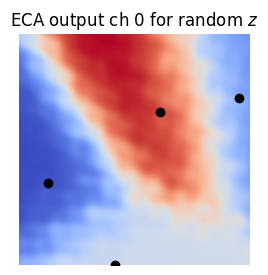

In [70]:
# Instantiate the model
eca = EquivariantCrossAttention(
    num_hidden=16,
    num_heads=2,
    bi_invariant=bi_invariant,
    embedding_freq_multiplier=3
)


# Create a random context vector for each latent
c = torch.rand(1, num_latents, 16) * 2 - 1  # (1, num_latents, 16)

# Create a gaussian window parameter for each latent
g = torch.ones((1, num_latents, 1)) * 0.5

# Apply the model
out = eca(x, p, c, g)

# Visualize the first channel of the output
out = out.detach().numpy()
plt.imshow(out[0, :, 0].reshape(num_steps, num_steps), cmap='coolwarm')
p_norm = (p + 1) / 2 * num_steps
plt.scatter(p_norm[0, :, 0].numpy(), p_norm[0, :, 1].numpy(), color='black', label='Latent')
plt.axis('off')
plt.title(r"ECA output ch 0 for random $z$")
plt.show()

In [71]:
# Configuration parameters
num_hidden = 32
num_heads = 2
num_out = 1
num_latents = 4
latent_dim = 16
freq_multiplier = 1
num_steps = 100

# Assuming bi_invariant is already defined and imported
bi_invariant = RnBiInvariant(num_dims=2)

# Instantiate the model
enf = EquivariantNeuralField(
    num_hidden=num_hidden,
    num_heads=num_heads,
    num_out=num_out,
    latent_dim = latent_dim,
    bi_invariant=bi_invariant,
    embedding_freq_multiplier=freq_multiplier
)

# Create a batch (with 1 sample) of 100 input coordinates on a 2D grid
x = np.stack(np.meshgrid(np.linspace(-1, 1, num_steps), np.linspace(-1, 1, num_steps)), axis=-1).reshape(-1, 2)[None, ...]
x = torch.tensor(x, dtype=torch.float32)  # (1, 10000, 2)

# Create a batch (with 1 sample) of 24 latent coordinates
p = torch.randn(1, num_latents, 2) * 0.5  # (1, num_latents, 2)

# Create a random context vector for each latent
c = torch.randn(1, num_latents, latent_dim) * 2 - 1  # (1, num_latents, 16)

# Create a gaussian window parameter for each latent
g = torch.ones((1, num_latents, 1)) * 0.2

# Apply the model
out = enf(x, p, c, g)

print(out)
# A quick normalization for visualization purposes
out = (out - out.min()) / (out.max() - out.min())
out = out.detach().numpy()
plt.imshow(out[0].reshape(num_steps, num_steps, 1), cmap='coolwarm')
p_norm = (p + 1) / 2 * num_steps
plt.scatter(p_norm[0, :, 0].numpy(), p_norm[0, :, 1].numpy(), color='black', label='Latent')
plt.axis('off')
plt.title(r"ENF output for random $z$")
plt.show()

tensor([[[-0.0088],
         [-0.0089],
         [-0.0089],
         ...,
         [-0.0022],
         [-0.0025],
         [-0.0035]]], grad_fn=<ViewBackward0>)


In [32]:
points, sdf = airfoil_sdf.sample_points()
print(points.shape)
print(sdf.shape)

(12920, 3)
(12920,)


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

# Optimizers
enf_optimizer = optim.Adam(enf.parameters(), lr=1e-4)
meta_sgd_lr_pose = nn.Parameter(torch.tensor(1.0))
meta_sgd_lr_context = nn.Parameter(torch.ones(latent_dim) * 0.5)
meta_sgd_optimizer = optim.Adam([meta_sgd_lr_pose, meta_sgd_lr_context], lr=1e-3)

def inner_loop(model, meta_sgd_lrs, x_i, y_i):
    # Initialize values for the poses
    p = torch.randn(x_i.size(0), num_latents, 2, requires_grad=True) * 0.5  # poses
    c = torch.ones(x_i.size(0), num_latents, latent_dim, requires_grad=True)  # context vectors
    g = torch.ones(x_i.size(0), num_latents, 1, requires_grad=True) * 2 / torch.sqrt(torch.tensor(num_latents, dtype=torch.float32))  # gaussian window parameter

    # Define the MSE loss function
    def mse_loss(z, x_i, y_i):
        p, c, g = z
        out = model(x_i, p, c, g)
        print(out[:,:10])
        print(y_i[:,:10])
        print(x_i[:,:10])
        return ((out - y_i) ** 2).mean()

    # Perform 3 inner steps
    for i in range(3):
        # Zero the gradients
        model.zero_grad()

        # Compute loss and gradients
        loss = mse_loss((p, c, g), x_i, y_i)
        grads = torch.autograd.grad(loss, [p, c, g], create_graph=True)

        # Update the latents
        with torch.no_grad():
            p -= meta_sgd_lrs[0] * grads[0]
            c -= meta_sgd_lrs[1] * grads[1]
        print(p,c)
    # Return loss with resulting latents from last inner loop step
    return mse_loss((p, c, g), x_i, y_i), (p, c, g)

def outer_step(x_i, y_i, model, meta_sgd_lrs, enf_optimizer, meta_sgd_optimizer):
    # Perform inner loop optimization
    loss, _ = inner_loop(model, meta_sgd_lrs, x_i, y_i)

    # Compute gradients for the outer step
    enf_optimizer.zero_grad()
    meta_sgd_optimizer.zero_grad()
    
    loss.backward()

    # Update the ENF backbone
    enf_optimizer.step()
    
    print(enf.parameters())
    # Update the meta SGD parameters
    meta_sgd_optimizer.step()

    return loss.item(), model, meta_sgd_lrs, enf_optimizer, meta_sgd_optimizer




In [67]:
from torch.utils.data import DataLoader, TensorDataset
# Sample points from airfoil_sdf
points, sdf = airfoil_sdf.sample_points()
points = points[:,:2]

# Normalize points and SDF values
points_mean = points.mean(axis=0)
points_std = points.std(axis=0)
points = (points - points_mean) / points_std

sdf_mean = sdf.mean()
sdf_std = sdf.std()
sdf = (sdf - sdf_mean) / sdf_std
batch_size = 1
# Subsample the dataset
subsample_size = 12000 # Define subsample size
indices = np.random.choice(len(points), subsample_size, replace=False)
points = points[indices]
sdf = sdf[indices]
points = torch.tensor(points, dtype=torch.float32).unsqueeze(0)
sdf = torch.tensor(sdf, dtype=torch.float32).unsqueeze(-1).unsqueeze(0)
dataset = TensorDataset(points, sdf)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = []
    for i, batch in enumerate(train_loader):
        # Unpack batch
        x_i, y_i = batch
        # Perform outer loop optimization
        loss, enf, [meta_sgd_lr_pose, meta_sgd_lr_context], enf_optimizer, meta_sgd_optimizer = outer_step(
            x_i, y_i, enf, [meta_sgd_lr_pose, meta_sgd_lr_context], enf_optimizer, meta_sgd_optimizer)
        
    for name, param in enf.named_parameters():
        if param.requires_grad:
            print(name, param.data)

        epoch_loss.append(loss)
    
    if not epoch % 1:
        print(f"Epoch {epoch} -- Loss: {np.mean(epoch_loss):.2f}")

tensor([[[ 0.0772, -0.4399,  0.8235, -1.2455, -0.3759, -0.1747, -0.4144,
           0.4568,  0.4216, -0.7475,  0.2552, -0.1366, -0.4668, -0.0765,
           0.6815, -0.3806,  0.0209, -0.6613, -0.9675,  0.1444, -0.1920,
          -0.0599,  0.1879,  0.0810, -0.4973, -0.2084, -0.4890, -0.9984,
           0.5807, -0.0724,  0.7698,  0.0464],
         [ 0.0772, -0.4399,  0.8235, -1.2455, -0.3759, -0.1747, -0.4144,
           0.4568,  0.4216, -0.7475,  0.2552, -0.1366, -0.4668, -0.0765,
           0.6815, -0.3806,  0.0209, -0.6613, -0.9675,  0.1444, -0.1920,
          -0.0599,  0.1879,  0.0810, -0.4973, -0.2084, -0.4890, -0.9984,
           0.5807, -0.0724,  0.7698,  0.0464],
         [ 0.0772, -0.4399,  0.8235, -1.2455, -0.3759, -0.1747, -0.4144,
           0.4568,  0.4216, -0.7475,  0.2552, -0.1366, -0.4668, -0.0765,
           0.6815, -0.3806,  0.0209, -0.6613, -0.9675,  0.1444, -0.1920,
          -0.0599,  0.1879,  0.0810, -0.4973, -0.2084, -0.4890, -0.9984,
           0.5807, -0.0724,  0

KeyboardInterrupt: 

In [40]:
print(points.shape)
print(sdf.shape)

torch.Size([12920, 2])
torch.Size([12920, 1, 1])
